In [1]:
rm(list=ls())

In [2]:
source("./ins_paquetes.R")

ins_paquetes('party','rpart','dplyr','caret','MLmetrics','haven',
             'mlr','UBL','ROSE','rpart.plot')

Warning message:
"package 'party' was built under R version 3.6.3"Warning message:
"package 'mvtnorm' was built under R version 3.6.3"Warning message:
"package 'modeltools' was built under R version 3.6.3"Warning message:
"package 'strucchange' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'sandwich' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'MLmetrics' was built under R version 3.6.3"
Attaching package: 'MLmetrics'

The following objects are masked fr


Bellow Packages Successfully Installed:

     party      rpart      dplyr      caret  MLmetrics      haven        mlr 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
       UBL       ROSE rpart.plot 
      TRUE       TRUE       TRUE 


In [3]:
########### 1) LIBRERIAS A UTILIZAR ################# 

library(party)
library(rpart)
library(dplyr)
library(caret)
library(MLmetrics)
library(haven)
library(mlr)
library(UBL)
library(ROSE)
library(rpart.plot)

In [4]:
#################################################################
####################### CLASIFICACION ########################### 
#################################################################

########### 2) DATA A UTILIZAR ################# 

## En Rstudio Cloud utilizar el siguiente comando
# datos <- read_sav("./Churn.sav")

## En Rstudio de escritorio utilizar el siguiente comando

datos <- haven::read_sav("./datasets/Churn.sav")
datos <- data.frame(datos)
datos <- datos %>% select(-ID)
#datos <- sqldf(" select EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN from datos")

In [5]:
########### 3) TRATAMIENTO DE LA DATA ################# 

## en primer lugar ver el analisis descriptivo de la data

datos$SEXO <- as.factor(datos$SEXO)
datos$CIVIL <- as.factor(datos$CIVIL)
datos$AUTO <- as.factor(datos$AUTO)
datos$CHURN <- as.factor(datos$CHURN)

resumen <- data.frame(mlr::summarizeColumns(datos))
write.csv(resumen,"tabla_resumen_clasificacion.csv")

In [6]:
head(datos)

EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN
57,1,1,2,27535.3,1,1
68,1,1,2,81000.9,2,1
34,2,2,0,87467.1,1,0
60,2,1,2,83220.6,2,1
28,1,1,2,20850.4,2,1
52,2,2,0,84112.6,2,0


In [7]:
########### 4) PARTICION MUESTRAL #################  

set.seed(123)
training.samples <- datos$CHURN %>% 
  createDataPartition(p = 0.7, list = FALSE)
train.data  <- datos[training.samples, ]
test.data <- datos[-training.samples, ]

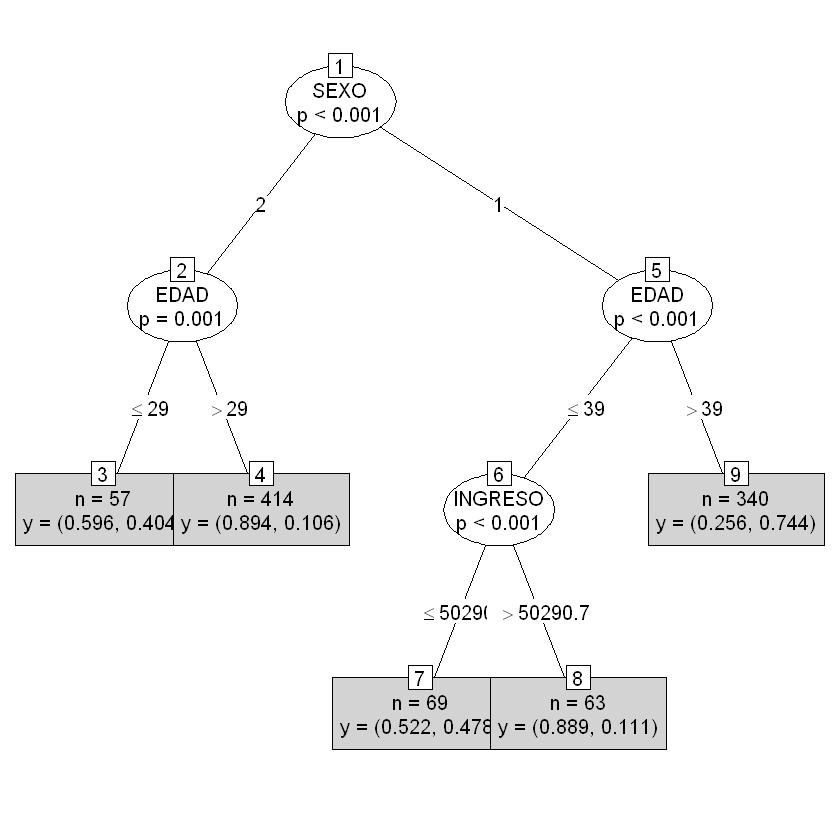

In [8]:
########### 5) MODELADO ########################### 

# modelo 1.- Arbol CHAID

n <- nrow(train.data) # numero de filas
# mincriterion: nivel de confianza para los x^2
# minbucket: criterio para el numero de casos en el nodo hijo
modelo1 <- party::ctree(CHURN~.,data = train.data, 
                 controls=ctree_control(mincriterion=0.95,minbucket = 0.05*n))

plot(modelo1 , cex=0.5,type="simple")

In [9]:
##probabilidades

proba1 <- sapply(predict(modelo1, newdata=test.data,type="prob"),'[[',2)
predit <- predict(modelo1, newdata=test.data) 

In [10]:
# Indicadores

AUC_1     <- MLmetrics::AUC(proba1,as.numeric(as.character(test.data$CHURN)))
GINI_1    <- 2*AUC_1-1
ks_1      <- MLmetrics::KS_Stat(proba1,as.numeric(as.character(test.data$CHURN)))
LogLoss_1 <- MLmetrics::LogLoss(proba1,as.numeric(as.character(test.data$CHURN)))

In [11]:
# Calcular los valores predichos

PRED <- as.factor(predit)

In [12]:
# Calcular la matriz de confusion
tabla <- caret::confusionMatrix(PRED,test.data$CHURN,positive = "1")
tabla

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 222  40
         1  27 113
                                          
               Accuracy : 0.8333          
                 95% CI : (0.7932, 0.8684)
    No Information Rate : 0.6194          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6406          
                                          
 Mcnemar's Test P-Value : 0.1426          
                                          
            Sensitivity : 0.7386          
            Specificity : 0.8916          
         Pos Pred Value : 0.8071          
         Neg Pred Value : 0.8473          
             Prevalence : 0.3806          
         Detection Rate : 0.2811          
   Detection Prevalence : 0.3483          
      Balanced Accuracy : 0.8151          
                                          
       'Positive' Class : 1               
                              

In [13]:
# sensibilidad
Sensitivity1 <-  MLmetrics::Sensitivity(PRED,test.data$CHURN)

In [14]:
# Precision
Accuracy1 <- MLmetrics::Accuracy(PRED,test.data$CHURN)

In [15]:
# modelo 2.- Arbol CART 

arbol.completo <- rpart::rpart(CHURN~.,data = train.data,method="class",cp=0, minbucket=0)

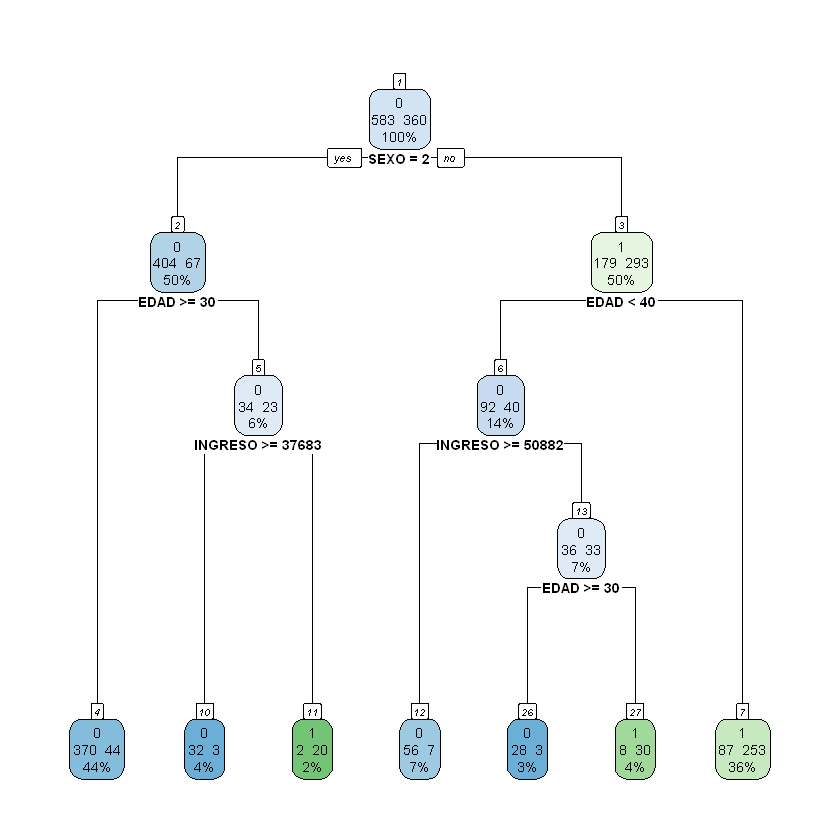

In [16]:
#rpart.plot::rpart.plot(arbol.completo, digits=-1, type=2, extra=101, cex = 0.7, nn=TRUE)

xerr    <- arbol.completo$cptable[,"xerror"] ## error de la validacion cruzada
minxerr <- which.min(xerr)
mincp   <- arbol.completo$cptable[minxerr, "CP"]

modelo2 <- rpart::prune(arbol.completo,cp=mincp)

rpart.plot::rpart.plot(modelo2, digits=-1, type=2, extra=101, cex = 0.7, nn=TRUE)

In [17]:
## probabilidades

proba2 <- predict(modelo2, newdata=test.data,type="prob")[,2]
predit <- predict(modelo2, newdata=test.data,type="class") 

In [18]:
# Indicadores

AUC_2     <- MLmetrics::AUC(proba2,as.numeric(as.character(test.data$CHURN)))
GINI_2    <- 2*AUC_2-1
ks_2      <- KS_Stat(proba2,as.numeric(as.character(test.data$CHURN)))
LogLoss_2 <- LogLoss(proba2,as.numeric(as.character(test.data$CHURN)))

In [19]:
# Calcular los valores predichos

PRED <- as.factor(predit)

In [20]:
# Calcular la matriz de confusion
tabla <- caret::confusionMatrix(PRED,test.data$CHURN,positive = "1")
tabla

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 212  25
         1  37 128
                                          
               Accuracy : 0.8458          
                 95% CI : (0.8067, 0.8797)
    No Information Rate : 0.6194          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6778          
                                          
 Mcnemar's Test P-Value : 0.1624          
                                          
            Sensitivity : 0.8366          
            Specificity : 0.8514          
         Pos Pred Value : 0.7758          
         Neg Pred Value : 0.8945          
             Prevalence : 0.3806          
         Detection Rate : 0.3184          
   Detection Prevalence : 0.4104          
      Balanced Accuracy : 0.8440          
                                          
       'Positive' Class : 1               
                              

In [21]:
# sensibilidad
Sensitivity2 <- MLmetrics::Sensitivity(PRED,test.data$CHURN)

In [22]:
# Precision
Accuracy2 <- MLmetrics::Accuracy(PRED,test.data$CHURN)

In [23]:
## --Tabla De Resultados ####

GINI <- rbind(GINI_1,
              GINI_2
)
KS <- rbind(ks_1,
            ks_2
)
LogLoss <- rbind(LogLoss_1,
                 LogLoss_2
)
Accuracy=rbind(Accuracy1,
               Accuracy2
)
Sensibilidad=rbind(Sensitivity1,
                   Sensitivity2
)

resultado <- data.frame(GINI,KS,LogLoss,Accuracy,Sensibilidad)
rownames(resultado) <- c('Chaid','Cart')
resultado <- round(resultado,2)
resultado

,GINI,KS,LogLoss,Accuracy,Sensibilidad
Chaid,0.73,63.52,0.43,0.83,0.85
Cart,0.67,68.80,0.44,0.85,0.89


In [24]:
## Resultado Ordenado #####

# ordenamos por el Indicador que deseamos, quiza Sensibilidad en forma decreciente
Resultado_ordenado <- resultado[order(-Sensibilidad),] 
Resultado_ordenado

,GINI,KS,LogLoss,Accuracy,Sensibilidad
Cart,0.67,68.80,0.44,0.85,0.89
Chaid,0.73,63.52,0.43,0.83,0.85
